# The goal of this file is to test PFGAP on Graphs

In [1]:
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm  # For a nice progress bar

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# PyTorch Geometric imports
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

# --- Load Dataset ---
print("Loading PROTEINS dataset...")
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')
print("Dataset loaded successfully.")
print("-" * 30)

# --- Your Distance Function ---
def graph_distance(graph1, graph2):
    """Calculates distance based on Laplacian spectra."""
    # Convert PyG graphs to NetworkX graphs
    # node_attrs=None and edge_attrs=None can speed this up
    g1_nx = to_networkx(graph1, node_attrs=None, edge_attrs=None)
    g2_nx = to_networkx(graph2, node_attrs=None, edge_attrs=None)
    
    spec1 = nx.laplacian_spectrum(g1_nx)
    spec2 = nx.laplacian_spectrum(g2_nx)
    
    # Use the smaller of the two spectrum lengths for comparison
    k = min(len(spec1), len(spec2))
    
    # Calculate the L2 norm (Euclidean distance) of the spectra
    return np.linalg.norm(spec1[:k] - spec2[:k])

#! Also run the edit distance
def edit_distance(graph1, graph2):
    """Calculates the edit distance between two graphs."""
    g1_nx = to_networkx(graph1, node_attrs=None, edge_attrs=None)
    g2_nx = to_networkx(graph2, node_attrs=None, edge_attrs=None)
    return nx.graph_edit_distance(g1_nx, g2_nx)


Loading PROTEINS dataset...
Dataset loaded successfully.
------------------------------


In [37]:
# Get the total number of graphs in the dataset
print(f"Total number of graphs in dataset: {len(dataset)}")

# Sample 100 random indices without replacement
SEED = 519
np.random.seed(SEED)  # For reproducibility
sample_indices = np.random.choice(len(dataset), size=1113, replace=False)

# Create a sample dataset (list of sampled graphs)
dataset = [dataset[i] for i in sample_indices]

print(f"Sampled {len(dataset)} graphs from the dataset")

# Show information about the first graph in the sample
first_graph = dataset[0]
print(f"\nFirst graph in sample:")
print(f"- Number of nodes: {first_graph.num_nodes}")
print(f"- Number of edges: {first_graph.num_edges}")
print(f"- Label: {first_graph.y.item()}")

Total number of graphs in dataset: 1113
Sampled 1113 graphs from the dataset

First graph in sample:
- Number of nodes: 68
- Number of edges: 286
- Label: 0


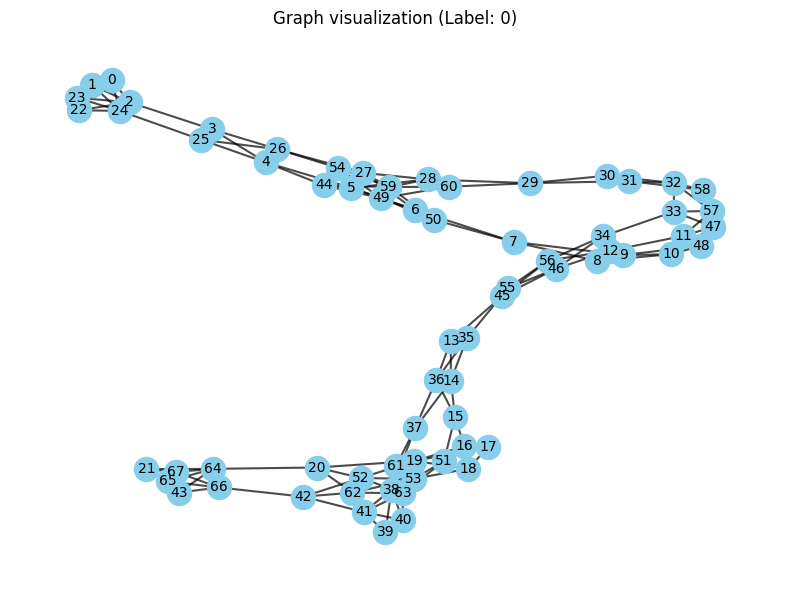

Graph stats:
- Number of nodes: 68
- Number of edges: 286
- Node feature dimensions: torch.Size([68, 3])
What first graph data is looks like Data(edge_index=[2, 286], x=[68, 3], y=[1])...


In [3]:
import matplotlib.pyplot as plt

# Convert PyG graph to NetworkX for visualization
g_nx = to_networkx(first_graph, to_undirected=True)

# Create a figure
plt.figure(figsize=(8, 6))

# Get positions for nodes using a layout algorithm
pos = nx.spring_layout(g_nx, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(g_nx, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(g_nx, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(g_nx, pos, font_size=10)

plt.title(f"Graph visualization (Label: {first_graph.y.item()})")
plt.axis('off')
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Graph stats:")
print(f"- Number of nodes: {first_graph.num_nodes}")
print(f"- Number of edges: {first_graph.num_edges}")
print(f"- Node feature dimensions: {first_graph.x.shape}")
print(f"What first graph data is looks like {first_graph}...")  # Show first 5 node features

In [ ]:
num_graphs = len(dataset)
# Initialize an empty square matrix to hold the distances
distance_matrix = np.zeros((num_graphs, num_graphs))

print(f"Calculating {num_graphs}x{num_graphs} distance matrix...")

# Use tqdm for a progress bar
for i in tqdm(range(num_graphs)):
    for j in range(i, num_graphs): # We only need to compute the upper triangle
        if i == j:
            continue # Distance to self is 0
        
        # Calculate and store the distance
        dist = graph_distance(dataset[i], dataset[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist # The matrix is symmetric

print("\nDistance matrix calculation complete!")
print(f"Shape of distance matrix: {distance_matrix.shape}")
#! This took 66 minutes and 8 seconsds on my machine

Calculating 1113x1113 distance matrix...


  0%|          | 0/1113 [00:00<?, ?it/s]


Distance matrix calculation complete!
Shape of distance matrix: (1113, 1113)


In [5]:
# Get the labels for each graph
labels = np.array([graph.y.item() for graph in dataset])

# Create an array of indices [0, 1, 2, ..., n-1]
indices = np.arange(num_graphs)

# Split indices and labels into training and testing sets
# We stratify by labels to ensure both sets have a similar class distribution
train_indices, test_indices, y_train, y_test = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)

# Now, create the training and testing distance matrices
# X_train should contain distances between all training samples
X_train_precomputed = distance_matrix[train_indices, :][:, train_indices]

# X_test should contain distances between test samples (rows) and training samples (columns)
X_test_precomputed = distance_matrix[test_indices, :][:, train_indices]


print(f"Shape of training distance matrix: {X_train_precomputed.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of testing distance matrix: {X_test_precomputed.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training distance matrix: (779, 779)
Shape of training labels: (779,)
Shape of testing distance matrix: (334, 779)
Shape of testing labels: (334,)


In [6]:
from sklearn.metrics import f1_score, confusion_matrix

# Initialize the classifier with k=5 neighbors
# IMPORTANT: We set metric='precomputed'
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

# Train the model
print("Training KNN classifier...")
knn.fit(X_train_precomputed, y_train)

# Make predictions on the test set
print("Making predictions...")
y_pred = knn.predict(X_test_precomputed)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)


f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print("-" * 30)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")

Training KNN classifier...
Making predictions...
F1 Score: 0.6137
Confusion Matrix:
[[142  57]
 [ 50  85]]
------------------------------
✅ Model Accuracy: 67.96%


In [7]:
# Get outlier (anomaly) scores for the train set using KNN
distances_train, _ = knn.kneighbors(X_train_precomputed, n_neighbors=knn.n_neighbors)
knn_outlier_scores_train = distances_train[:, -1]  # Distance to the k-th nearest neighbor
print("KNN outlier scores for train set:", knn_outlier_scores_train)


KNN outlier scores for train set: [1.05063515e+00 8.58413435e-01 1.53073373e+00 8.95365061e-01
 2.00713070e+00 8.30226000e-01 0.00000000e+00 1.07092597e+00
 8.51932719e-01 1.76679679e+00 9.03939166e-01 6.65163032e-01
 1.00532937e+00 1.34395725e+00 3.76208373e-15 5.62752317e+00
 6.17323328e-15 1.05985351e+00 2.22743633e+00 0.00000000e+00
 1.02755696e+00 1.06855228e+00 1.47991836e+00 7.76831160e-01
 1.38265531e+00 2.62302717e+00 9.76285570e-01 9.51939777e-01
 8.88178420e-16 2.05653132e+00 1.29371909e+00 7.64931701e-01
 4.25535811e+00 1.04649272e+00 1.07663539e+00 3.00976671e+00
 3.01566710e+00 1.15305807e+00 1.37885829e+00 4.02621866e-15
 0.00000000e+00 1.05425622e+00 1.04100398e+00 1.81170734e+00
 8.24161823e-01 1.11057057e+00 1.91389927e+00 1.03643701e+00
 9.41936189e-01 6.87260098e+00 9.09269476e-01 1.48499445e+00
 5.62092662e-01 1.13775930e+00 1.04260262e+00 2.41387488e+00
 6.28554489e-01 1.05384757e+00 4.33800335e-01 4.50701324e-15
 1.92149514e+00 1.11731938e+00 2.71039982e-15 1.024

In [8]:
import pandas as pd
import os
import json

# Create a results directory if it doesn't exist
results_dir = os.path.join('/yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5', 'results')
os.makedirs(results_dir, exist_ok=True)

# Store KNN model results in a single row dataframe
model_results = pd.DataFrame({
    'model': 'knn',
    'seed': SEED,
    'accuracy': accuracy,
    'f1_score': f1,
    'confusion_matrix': json.dumps(cm.tolist()),  # Save as JSON string
    'outlier_scores': [knn_outlier_scores_train]
})

# Save to CSV
model_results_path = os.path.join(results_dir, f'knn_model_results{SEED}.csv')
model_results.to_csv(model_results_path, index=False)
print(f"KNN model results saved to: {model_results_path}")

# Display the dataframe
knn_results = model_results
model_results

KNN model results saved to: /yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5/results/knn_model_results519.csv


,model,seed,accuracy,f1_score,confusion_matrix,outlier_scores
0,knn,519,0.679641,0.613718,"[[142, 57], [50, 85]]","[1.0506351536377638, 0.8584134351836902, 1.530..."


In [9]:
model_results["outlier_scores"].values

array([array([1.05063515e+00, 8.58413435e-01, 1.53073373e+00, 8.95365061e-01,
              2.00713070e+00, 8.30226000e-01, 0.00000000e+00, 1.07092597e+00,
              8.51932719e-01, 1.76679679e+00, 9.03939166e-01, 6.65163032e-01,
              1.00532937e+00, 1.34395725e+00, 3.76208373e-15, 5.62752317e+00,
              6.17323328e-15, 1.05985351e+00, 2.22743633e+00, 0.00000000e+00,
              1.02755696e+00, 1.06855228e+00, 1.47991836e+00, 7.76831160e-01,
              1.38265531e+00, 2.62302717e+00, 9.76285570e-01, 9.51939777e-01,
              8.88178420e-16, 2.05653132e+00, 1.29371909e+00, 7.64931701e-01,
              4.25535811e+00, 1.04649272e+00, 1.07663539e+00, 3.00976671e+00,
              3.01566710e+00, 1.15305807e+00, 1.37885829e+00, 4.02621866e-15,
              0.00000000e+00, 1.05425622e+00, 1.04100398e+00, 1.81170734e+00,
              8.24161823e-01, 1.11057057e+00, 1.91389927e+00, 1.03643701e+00,
              9.41936189e-01, 6.87260098e+00, 9.09269476e-01, 1.

# PFGAP

In [ ]:
import sys
import os
import pickle
import pandas as pd
import numpy as np

# Add the Application directory to the Python path so we can import proxUtil
sys.path.append('/yunity/arusty/PF-GAP-1/PFGAP/Application')
import proxUtil

# Create a directory for our graph experiment data
experiment_dir = '/yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5'
data_dir = os.path.join(experiment_dir, 'graph_data')
os.makedirs(data_dir, exist_ok=True)

print("🚀 Implementing INDEXING approach for PFGAP with graphs")

# Prepare ALL graphs (train + test) in a single indexed collection
all_graphs = []
all_labels = []
graph_to_original_mapping = {}  # Maps new index -> (dataset_type, original_index)

# Add training graphs first
for i, graph_idx in enumerate(train_indices):
    all_graphs.append(dataset[graph_idx])
    all_labels.append(y_train[i])
    graph_to_original_mapping[len(all_graphs)-1] = ('train', i)

# Add test graphs
train_count = len(all_graphs)
for i, graph_idx in enumerate(test_indices):
    all_graphs.append(dataset[graph_idx])
    all_labels.append(y_test[i])
    graph_to_original_mapping[len(all_graphs)-1] = ('test', i)

print(f"📊 Total graphs: {len(all_graphs)} (Training: {train_count}, Test: {len(all_graphs)-train_count})")

# Save the complete graph collection for the distance function
graphs_data = {
    'graphs': all_graphs,
    'labels': all_labels,
    'train_count': train_count,
    'mapping': graph_to_original_mapping
}

graphs_file = os.path.join(data_dir, 'indexed_graphs.pkl')
with open(graphs_file, 'wb') as f:
    pickle.dump(graphs_data, f)

# Create TSV files with indices and dummy features
def create_indexed_tsv(start_idx, end_idx, labels_subset, filename):
    """
    Create a TSV file where each row contains: label, index, dummy_feature
    """
    rows = []
    for i, (graph_index, label) in enumerate(zip(range(start_idx, end_idx), labels_subset)):
        rows.append([label, graph_index, 0.0])
    
    df = pd.DataFrame(rows)
    tsv_path = os.path.join(data_dir, filename)
    df.to_csv(tsv_path, sep='\t', header=False, index=False)
    return tsv_path

# Create training and test TSVs
train_tsv = create_indexed_tsv(0, train_count, y_train, 'indexed_train.tsv')
test_tsv = create_indexed_tsv(train_count, len(all_graphs), y_test, 'indexed_test.tsv')

print(f"📝 Created TSV files: {os.path.basename(train_tsv)}, {os.path.basename(test_tsv)}")

print("\n🚀 TRAINING PFGAP WITH INDEXED GRAPHS")

# Change to the Application directory so PFGAP can find the JAR files
original_cwd = os.getcwd()
os.chdir('/yunity/arusty/PF-GAP-1/PFGAP/Application')

try:
    # Train PFGAP model using the python distance function
    proxUtil.getProx(
        trainfile=train_tsv,
        testfile=test_tsv,
        modelname="IndexedGraphPFGAP",
        distances=['python'],  # Use our custom indexed graph distance function
        num_trees=11,
        r=5,
        getprox="true",
        savemodel="true",
        out="indexed_graph_output",
        verbosity=2,
        csv_has_header="false",
        target_column="first", 
        parallelTrees="true"
    )
    
    print("\n🎉 PFGAP training completed")
    
    # Read the results
    try:
        # Read predictions
        with open("Predictions.txt", 'r') as f:
            pred_content = f.read()
            pfgap_predictions = eval("np.array(" + pred_content + ")")
        
        # Calculate accuracy
        pfgap_accuracy = accuracy_score(y_test, pfgap_predictions)
        if pfgap_accuracy < .5:
            pfgap_predictions = 1 - pfgap_predictions
            pfgap_accuracy = accuracy_score(y_test, pfgap_predictions)
        print(f"🎯 PFGAP Model Accuracy: {pfgap_accuracy * 100:.2f}%")
        
    except Exception as e:
        print(f"❌ Error reading PFGAP results: {e}")
        
except Exception as e:
    print(f"❌ Error running PFGAP: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Change back to original directory
    os.chdir(original_cwd)

#! This took 66 minues, and 52 seconds on my machine


🚀 Implementing INDEXING approach for PFGAP with graphs
📊 Total graphs: 1113 (Training: 779, Test: 334)
📝 Created TSV files: indexed_train.tsv, indexed_test.tsv

🚀 TRAINING PFGAP WITH INDEXED GRAPHS
reading file [indexed_test.tsv]:finished in 0:0:0.006
reading file [indexed_train.tsv]:finished in 0:0:0.004
Running on configurations...
Dataset: indexed_train.tsv, Training Data : 779x2 , Testing Data: 334x2, Train #Classes: 2, Test #Classes: 2
Repeats: 1 , Trees: 11 , Candidates per Split(r): 5
Output Dir: indexed_graph_output, Export: 1, Verbosity: 2
Select DM per node: true , Shuffle Data: false, JVM WarmUp: false
----------------------------------------------------------------------------------------------------

-----------------Repetition No: 1 (indexed_train.tsv)   -----------------
Using: 4 MB, Free: 20 MB, Allocated Pool: 24 MB, Max Available: 1024 MB
core.ProximityForestResult@4783da3f


9.(19/24MB) 8.(17/24MB) 0.(11/24MB) 6.(12/24MB) 7.(16/24MB) 10.(11/24MB) 4.(16/24MB) 5.(14/24MB) 2.(17/24MB) 1.(13/24MB) 3.(19/24MB) 
Using: 19 MB, Free: 5 MB, Allocated Pool: 24 MB, Max Available: 1024 MB
****
Computing Forest Proximities...
Done Computing Forest Proximities. Computation time: 10899.0ms
Training Time: 3679094.410551ms (1:1:19.094)
Prediction Time: 300040.363044ms (0:5:0.040)
Correct(TP+TN): 229 vs Incorrect(FP+FN): 105
Accuracy: 0.6856287425149701
Error Rate: 0.3143712574850299
REPEAT:1 ,indexed_train.tsv, 0.6856287425149701, 3679094.410551, 300040.363044, 16.363636363636363

🎉 PFGAP training completed
🎯 PFGAP Model Accuracy: 68.56%


In [11]:
import pandas as pd
import os
import json
from sklearn.metrics import f1_score, confusion_matrix
from proxUtil import getProxArrays, SymmetrizeProx, getOutlierScores
import sys

sys.path.append('/yunity/arusty/PF-GAP-1/PFGAP/Application')

# Calculate metrics for PFGAP
pfgap_f1 = f1_score(y_test, pfgap_predictions)
pfgap_cm = confusion_matrix(y_test, pfgap_predictions)

# Try to read PFGAP proximity values for outlier detection
pfgap_outlier_scores = None
prox_file = "/yunity/arusty/PF-GAP-1/PFGAP/Application/ForestProximities.txt"
y_file = "/yunity/arusty/PF-GAP-1/PFGAP/Application/ytrain.txt"
prox_array, y_array = getProxArrays(str(prox_file), str(y_file))
prox_sym = SymmetrizeProx(prox_array)
pfgap_outlier_scores = getOutlierScores(prox_sym, y_array)
                            
# Store PFGAP model results in a dataframe (similar to KNN)
# Convert outlier scores to a Python list of floats for natural storage
pfgap_results = pd.DataFrame({
    'model': 'pfgap',
    'seed': SEED,
    'accuracy': pfgap_accuracy,
    'f1_score': pfgap_f1,
    'confusion_matrix': json.dumps(pfgap_cm.tolist()),
    'outlier_scores': [list(map(float, pfgap_outlier_scores))]
})

# Save PFGAP results to CSV
pfgap_results_path = os.path.join(results_dir, f'pfgap_model_results{SEED}.csv')
pfgap_results.to_csv(pfgap_results_path, index=False)
print(f"PFGAP model results saved to: {pfgap_results_path}")

PFGAP model results saved to: /yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5/results/pfgap_model_results519.csv


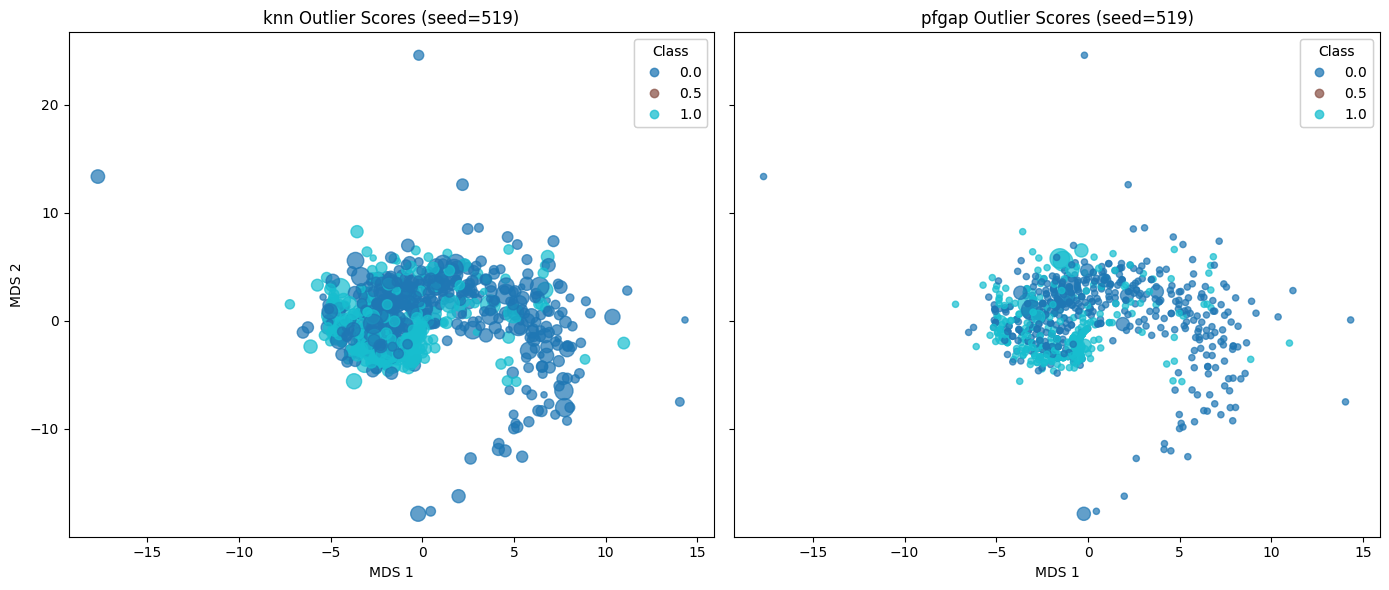

In [33]:
# --- Load Dataset ---
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS


dataset_full = TUDataset(root='data/TUDataset', name='PROTEINS')
import ast


# Extract outlier scores for both models and convert from string to list
scores_knn = pfgap_results
scores_pfgap = knn_results

# Convert string representation to list/array if necessary
if isinstance(scores_knn, str):
    try:
        # Try ast.literal_eval first (for Python list-like strings)
        scores_knn = ast.literal_eval(scores_knn)
    except Exception:
        # If it fails, try numpy fromstring (for numpy array-like strings)
        scores_knn = np.fromstring(scores_knn.replace('\n', ' ').replace('[','').replace(']',''), sep=' ')
if isinstance(scores_pfgap, str):
    try:
        scores_pfgap = ast.literal_eval(scores_pfgap)
    except Exception:
        scores_pfgap = np.fromstring(scores_pfgap.replace('\n', ' ').replace('[','').replace(']',''), sep=' ')


np.random.seed(SEED)  # For reproducibility
sample_indices = np.random.choice(len(dataset_full), size=250, replace=False)

# Create a sample dataset (list of sampled graphs)
dataset = [dataset_full[i] for i in range(len(dataset_full))]
labels = np.array([graph.y.item() for graph in dataset])

# Create an array of indices [0, 1, 2, ..., n-1]
indices = np.arange(len(dataset))

# Split indices and labels into training and testing sets
# We stratify by labels to ensure both sets have a similar class distribution
train_indices, test_indices, y_train, y_test = train_test_split(
    indices, labels, test_size=0.3, random_state=SEED, stratify=labels
)

# Apply MDS to graph data (flatten node features for each graph)
graph_features = [dataset[i].x.flatten().cpu().numpy() for i in train_indices]
max_len = max(f.shape[0] for f in graph_features)

# Pad all feature vectors to the same length
graph_features_padded = np.array([np.pad(f, (0, max_len - f.shape[0])) for f in graph_features])
mds = MDS(n_components=2, random_state=42)
coords = mds.fit_transform(graph_features_padded)

def parse_scores(scores):
    """
    Convert string-representation of scores into a NumPy array.
    If already an array, just return it.
    """
    if isinstance(scores, str):
        try:
            # Try to interpret as Python list-like string
            scores = np.array(ast.literal_eval(scores), dtype=float)
        except Exception:
            # Fallback: parse as space-separated values
            scores = np.fromstring(
                scores.replace('\n', ' ').replace('[','').replace(']',''),
                sep=' ',
                dtype=float
            )
    else:
        scores = np.array(scores, dtype=float)
    return scores

# Normalize outlier scores for marker size
def normalize_scores(scores, min_size=20, max_size=200):
    scores = np.array(scores, dtype=float)

    # Replace NaNs with the 0
    if np.isnan(scores).all():
        return np.full_like(scores, min_size, dtype=float)
    scores = np.nan_to_num(scores, nan=0)

    # Handle constant values (ptp == 0)
    ptp = np.ptp(scores)
    if ptp == 0:
        return np.full_like(scores, min_size, dtype=float)

    # Normalize to [0, 1]
    norm = (scores - np.min(scores)) / ptp
    return min_size + norm * (max_size - min_size)

sizes_knn = normalize_scores(parse_scores(pd.read_csv('results/knn_model_results519.csv')['outlier_scores'].values[0]))
sizes_pfgap = normalize_scores(parse_scores(pd.read_csv('results/pfgap_model_results519.csv')['outlier_scores'].values[0]))

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

scatter0 = axes[0].scatter(coords[:, 0], coords[:, 1], c=y_train, s=sizes_knn, cmap='tab10', alpha=0.7)
axes[0].set_title(f'knn Outlier Scores (seed={SEED})')
axes[0].set_xlabel('MDS 1')
axes[0].set_ylabel('MDS 2')
legend1 = axes[0].legend(*scatter0.legend_elements(prop="colors", num=len(np.unique(y_train))),
                         title="Class", loc="upper right")
axes[0].add_artist(legend1)

scatter1 = axes[1].scatter(coords[:, 0], coords[:, 1], c=y_train, s=sizes_pfgap, cmap='tab10', alpha=0.7)
axes[1].set_title(f'pfgap Outlier Scores (seed={SEED})')
axes[1].set_xlabel('MDS 1')
legend2 = axes[1].legend(*scatter1.legend_elements(prop="colors", num=len(np.unique(y_train))),
                         title="Class", loc="upper right")
axes[1].add_artist(legend2)

plt.tight_layout()
plt.show()

In [39]:
sizes_knn.shape, sizes_pfgap.shape, y_train.shape, embedding_knn[:, 0].shape

((779,), (779,), (779,), (1113,))

/yunity/arusty/miniconda3/envs/tsimpute/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/yunity/arusty/miniconda3/envs/tsimpute/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/yunity/arusty/miniconda3/envs/tsimpute/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/yunity/arusty/miniconda3/envs/tsimpute/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


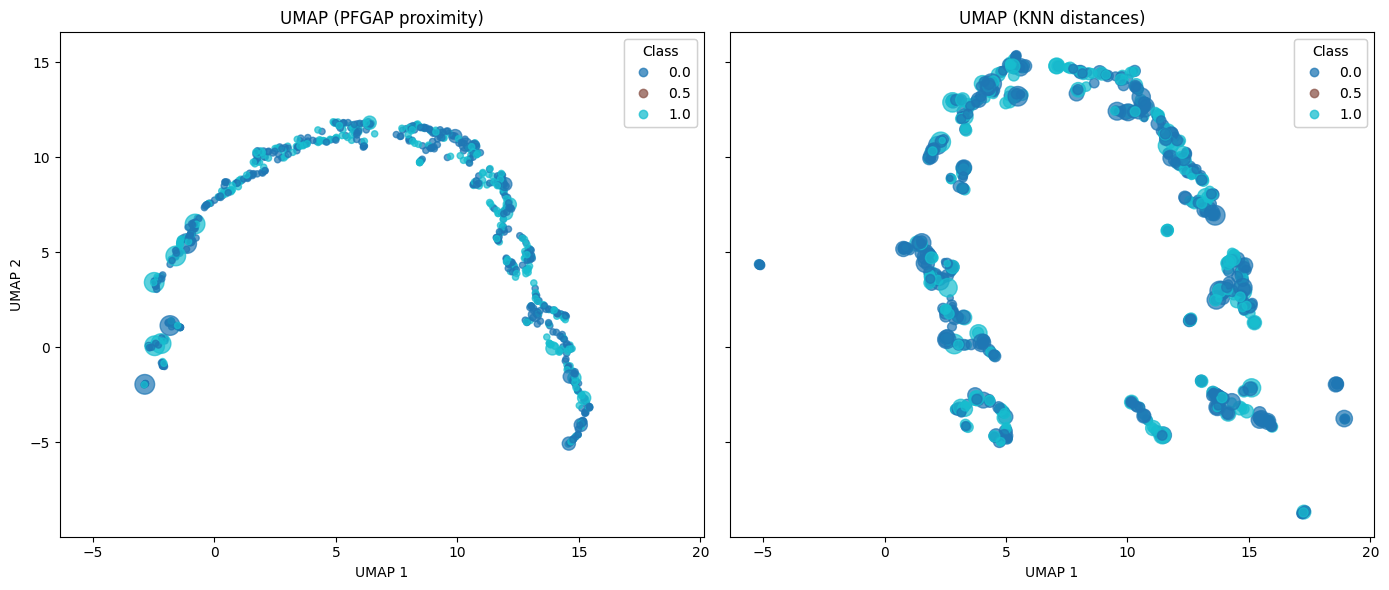

In [44]:
import umap
import matplotlib.pyplot as plt

# -----------------------
# --- PFGAP + UMAP ------
# -----------------------
# Ensure prox_sym is a numpy array (n x n) of distances
embedding_pfgap = umap.UMAP(
    n_neighbors=knn.n_neighbors,          # controls local vs global structure
    min_dist=0.1,            # smaller = more clustered embedding
    n_components=2,
    metric="precomputed",
    random_state=42
).fit_transform(1 -prox_sym)

# -----------------------
# --- KNN + UMAP --------
# -----------------------
# If you have KNN model, we can build a precomputed distance matrix
embedding_knn = umap.UMAP(
    n_neighbors=knn.n_neighbors,
    min_dist=0.1,
    n_components=2,
    metric="precomputed",
    random_state=42
).fit_transform(distance_matrix[train_indices, :][:, train_indices])

# -----------------------
# --- Plotting ----------
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

scatter0 = axes[0].scatter(embedding_pfgap[:, 0], embedding_pfgap[:, 1],
                           c=y_train, s=sizes_pfgap, cmap="tab10", alpha=0.7)
axes[0].set_title("UMAP (PFGAP proximity)")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
legend0 = axes[0].legend(*scatter0.legend_elements(prop="colors", num=len(np.unique(y_train))),
                         title="Class", loc="upper right")
axes[0].add_artist(legend0)

scatter1 = axes[1].scatter(embedding_knn[:, 0], embedding_knn[:, 1],
                           c=y_train, s=sizes_knn, cmap="tab10", alpha=0.7)
axes[1].set_title("UMAP (KNN distances)")
axes[1].set_xlabel("UMAP 1")
legend1 = axes[1].legend(*scatter1.legend_elements(prop="colors", num=len(np.unique(y_train))),
                         title="Class", loc="upper right")
axes[1].add_artist(legend1)

plt.tight_layout()
plt.show()
